In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [24]:
# טענת הנתונים
df = pd.read_csv('flight_data_kiwi_allsnaps_clean.csv')

# הצצה לנתונים
print(df.head())
print(df.info())

    Snap Date    Dep Date Return Date  Outbound Dep Time Dep Duration  \
0  2025-03-02  2025-03-03  2025-03-04  Outbound    11:50       1h 10m   
1  2025-03-02  2025-03-03  2025-03-04  Outbound    13:20       1h 20m   
2  2025-03-02  2025-03-03  2025-03-04  Outbound    18:35       1h 20m   
3  2025-03-02  2025-03-03  2025-03-04  Outbound    07:10       1h 20m   
4  2025-03-02  2025-03-03  2025-03-04  Outbound    19:25       1h 15m   

  Dep Arrival From Stops Landing  Inbound Back Time Back Duration  \
0       14:00  SEN     0     CDG  Inbound     14:10        1h 15m   
1       15:40  LTN     0     CDG  Inbound     14:10        1h 15m   
2       20:55  LTN     0     CDG  Inbound     14:10        1h 15m   
3       09:30  LTN     0     CDG  Inbound     14:10        1h 15m   
4       21:40  LGW     0     ORY  Inbound     14:10        1h 15m   

  Back Arrival From.1 Stops.1 Landing.1 Dep Company Back Company  Price  
0        14:25    ORY       0       LHR     easyJet      easyJet  ₪ 434 

/var/folders/3b/jd8k5j055rx3c991jlh5x05h0000gn/T/ipykernel_41419/3271987678.py:2: DtypeWarning: Columns (8,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flight_data_kiwi_allsnaps_clean.csv')


In [25]:
# 1. בדיקה שהעמודה קיימת
print(df.columns)

# 2. הצצה בכמה ערכים ראשונים
print(df['Price'].head(10))

# 3. בדיקת סוג העמודה
print("Column type:", df['Price'].dtype)

# 4. אם היא כבר float, אולי אין צורך בהחלפה. 
#    אם היא object/string, ננסה לנקות תווים.

df['Price'] = df['Price'].astype(str)  # ממיר הכל למחרוזת, אם עדיין לא
df['Price'] = df['Price'].str.replace('₪', '', regex=False)
df['Price'] = df['Price'].str.replace(',', '', regex=False)

# 5. בדיקת ערכים חריגים
unique_vals = df['Price'].unique()
print(unique_vals[:50])  # תצוגה של 50 ערכים ראשונים

# 6. המרה למספרים
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 7. בדיקת כמה NaN נוצרו
nan_count = df['Price'].isna().sum()
print("Number of NaN after conversion:", nan_count)

# אם יש NaN, מחליטים איך לטפל: להסיר שורות? למלא ערך ממוצע? וכו'
df = df.dropna(subset=['Price'])  # לדוגמה, הסרה של שורות בלי מחיר תקין


Index(['Snap Date', 'Dep Date', 'Return Date', 'Outbound', 'Dep Time',
       'Dep Duration', 'Dep Arrival', 'From', 'Stops', 'Landing', 'Inbound',
       'Back Time', 'Back Duration', 'Back Arrival', 'From.1', 'Stops.1',
       'Landing.1', 'Dep Company', 'Back Company', 'Price'],
      dtype='object')
0    ₪ 434
1    ₪ 434
2    ₪ 434
3    ₪ 444
4    ₪ 454
5    ₪ 454
6    ₪ 452
7    ₪ 463
8    ₪ 485
9    ₪ 485
Name: Price, dtype: object
Column type: object
[' 434' ' 444' ' 454' ' 452' ' 463' ' 485' ' 481' ' 479' ' 487' ' 488'
 ' 495' ' 493' ' 505' ' 503' ' 509' ' 510' ' 507' ' 515' ' 516' ' 520'
 ' 531' ' 527' ' 526' ' 529' ' 525' ' 539' ' 537' ' 544' ' 540' ' 548'
 ' 546' ' 561' ' 557' ' 564' ' 570' ' 568' ' 563' ' 566' ' 569' ' 418'
 ' 428' ' 438' ' 436' ' 448' ' 466' ' 460' ' 472' ' 476' ' 477' ' 486']
Number of NaN after conversion: 2


In [26]:
df.head()

,Snap Date,Dep Date,Return Date,Outbound,Dep Time,Dep Duration,Dep Arrival,From,Stops,Landing,Inbound,Back Time,Back Duration,Back Arrival,From.1,Stops.1,Landing.1,Dep Company,Back Company,Price
0,2025-03-02,2025-03-03,2025-03-04,Outbound,11:50,1h 10m,14:00,SEN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,434.0
1,2025-03-02,2025-03-03,2025-03-04,Outbound,13:20,1h 20m,15:40,LTN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,434.0
2,2025-03-02,2025-03-03,2025-03-04,Outbound,18:35,1h 20m,20:55,LTN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,434.0
3,2025-03-02,2025-03-03,2025-03-04,Outbound,07:10,1h 20m,09:30,LTN,0,CDG,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,444.0
4,2025-03-02,2025-03-03,2025-03-04,Outbound,19:25,1h 15m,21:40,LGW,0,ORY,Inbound,14:10,1h 15m,14:25,ORY,0,LHR,easyJet,easyJet,454.0


In [27]:
df['Snap Date'] = pd.to_datetime(df['Snap Date'])
df['Dep Date'] = pd.to_datetime(df['Dep Date'])
df['Return Date'] = pd.to_datetime(df['Return Date'])
df['dep_weekday'] = df['Dep Date'].dt.weekday  # ערך 0-6
df['dep_day'] = df['Dep Date'].dt.day         # ערך 1-31
df['dep_month'] = df['Dep Date'].dt.month     # ערך 1-12
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x>=5 else 0)

In [28]:
def convert_duration_to_minutes(duration_str):
    # לדוגמה: "1h 20m" -> 80
    parts = duration_str.split()
    total_minutes = 0
    for p in parts:
        if 'h' in p:
            total_minutes += int(p.replace('h', '')) * 60
        elif 'm' in p:
            total_minutes += int(p.replace('m', ''))
    return total_minutes

df['Dep Duration (min)'] = df['Dep Duration'].apply(convert_duration_to_minutes)
df['Back Duration (min)'] = df['Back Duration'].apply(convert_duration_to_minutes)
df['TTT'] = (df['Dep Date'] - df['Snap Date']).dt.days

In [29]:
features = ['Stops','Dep Duration (min)','Back Duration (min)','dep_weekday','dep_day','dep_month',]
for i in features:
    X = df[features]
    y = df['Price']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # אימון
    model.fit(X_train, y_train)
    
    # ניבוי
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # חישוב מדדים
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    # Residual Plot
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred_test, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.show()
    
    return model


=== Linear Regression ===
Train -> R2: 0.234, MSE: 24753.08, RMSE: 157.33, MAE: 126.11
Test  -> R2: 0.233,  MSE: 24680.09,  RMSE: 157.10,  MAE: 126.28


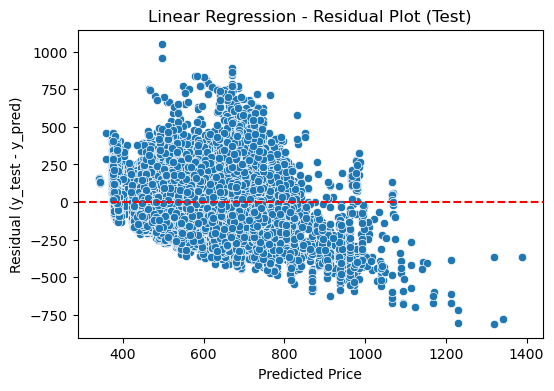

In [32]:
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.404, MSE: 19239.28, RMSE: 138.71, MAE: 106.06
Test  -> R2: 0.404,  MSE: 19179.01,  RMSE: 138.49,  MAE: 106.33


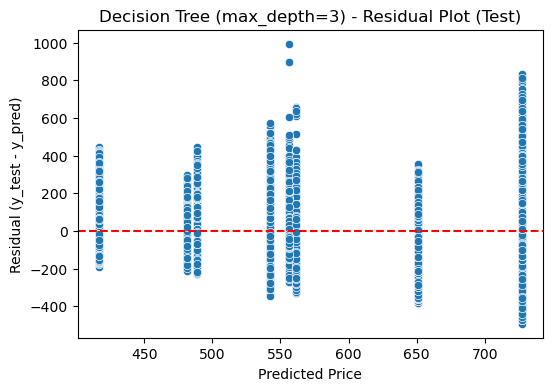

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.520, MSE: 15522.47, RMSE: 124.59, MAE: 95.50
Test  -> R2: 0.515,  MSE: 15595.71,  RMSE: 124.88,  MAE: 95.97


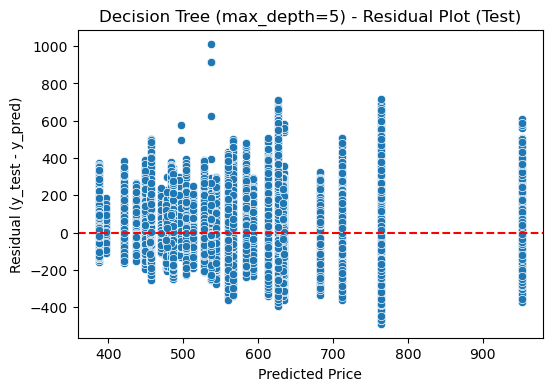

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.586, MSE: 13365.83, RMSE: 115.61, MAE: 88.36
Test  -> R2: 0.580,  MSE: 13523.21,  RMSE: 116.29,  MAE: 88.97


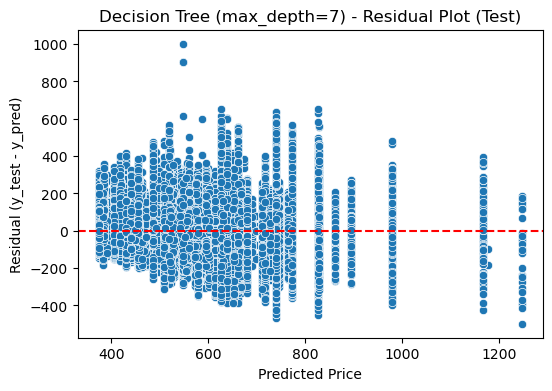

In [33]:
for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.999, MSE: 28.13, RMSE: 5.30, MAE: 0.75
Test  -> R2: -9.417,  MSE: 335114.63,  RMSE: 578.89,  MAE: 536.86


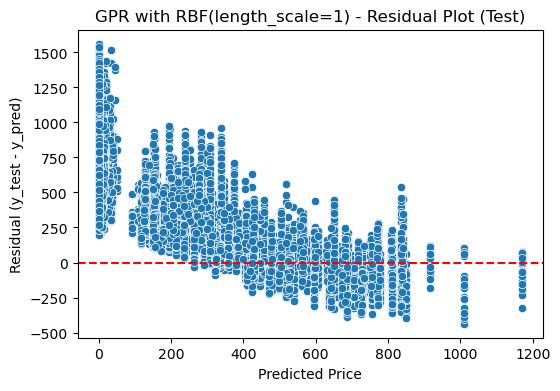

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.261, MSE: 21091.88, RMSE: 145.23, MAE: 122.59
Test  -> R2: 0.156,  MSE: 27137.42,  RMSE: 164.73,  MAE: 129.92


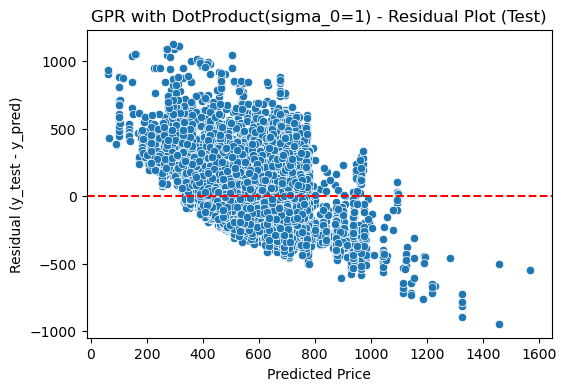

In [34]:
subset_size = 100  # למשל 100 דוגמאות
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       # ביטול האופטימיזציה
            alpha=1e-6,           # להבטיח יציבות במספרים
            random_state=42
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")



=== Random Forest (max_depth=3) ===
Train -> R2: 0.405, MSE: 19211.48, RMSE: 138.61, MAE: 105.95
Test  -> R2: 0.405,  MSE: 19151.49,  RMSE: 138.39,  MAE: 106.23


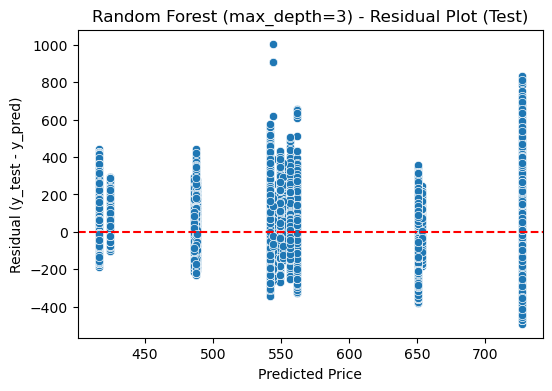

=== Random Forest (max_depth=5) ===
Train -> R2: 0.524, MSE: 15378.29, RMSE: 124.01, MAE: 94.98
Test  -> R2: 0.520,  MSE: 15448.33,  RMSE: 124.29,  MAE: 95.43


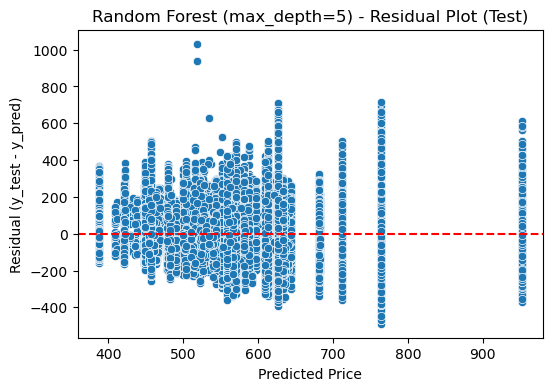

=== Random Forest (max_depth=8) ===
Train -> R2: 0.622, MSE: 12226.23, RMSE: 110.57, MAE: 84.56
Test  -> R2: 0.614,  MSE: 12432.02,  RMSE: 111.50,  MAE: 85.35


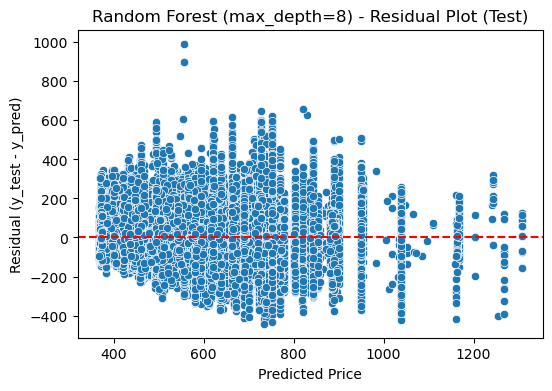

In [35]:
for md in [3, 5, 8]:  # דוגמה לאופטימיזציה בסיסית על עומק העצים
    rf = RandomForestRegressor(n_estimators=100, max_depth=md, random_state=42)
    model_name = f"Random Forest (max_depth={md})"
    trained_rf = train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, model_name)


=== KNN Regressor (n_neighbors=3) ===
Train -> R2: 0.600, MSE: 12914.88, RMSE: 113.64, MAE: 85.33
Test  -> R2: 0.575,  MSE: 13661.50,  RMSE: 116.88,  MAE: 87.95


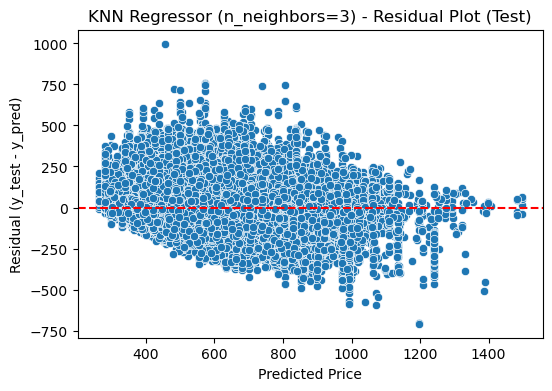

=== KNN Regressor (n_neighbors=5) ===
Train -> R2: 0.638, MSE: 11701.87, RMSE: 108.18, MAE: 81.84
Test  -> R2: 0.615,  MSE: 12400.43,  RMSE: 111.36,  MAE: 84.35


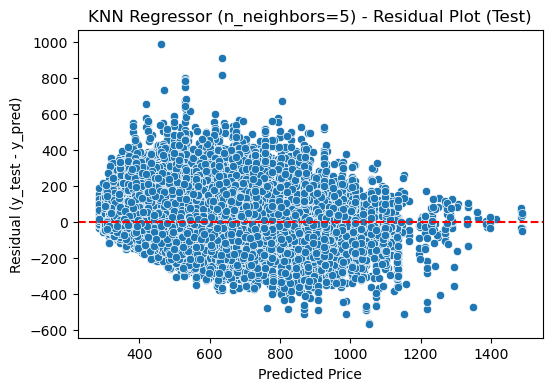

=== KNN Regressor (n_neighbors=10) ===
Train -> R2: 0.661, MSE: 10953.64, RMSE: 104.66, MAE: 79.66
Test  -> R2: 0.642,  MSE: 11530.33,  RMSE: 107.38,  MAE: 81.79


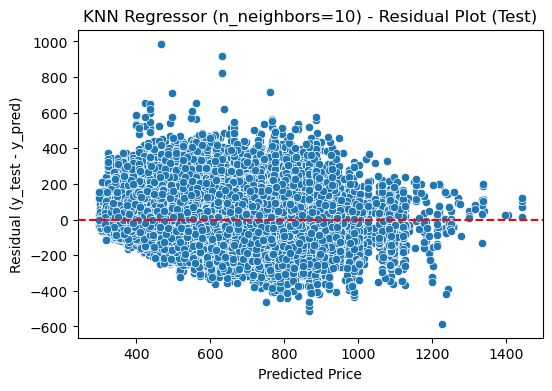

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.518, MSE: 15559.14, RMSE: 124.74, MAE: 97.69
Test  -> R2: 0.516,  MSE: 15581.09,  RMSE: 124.82,  MAE: 97.94


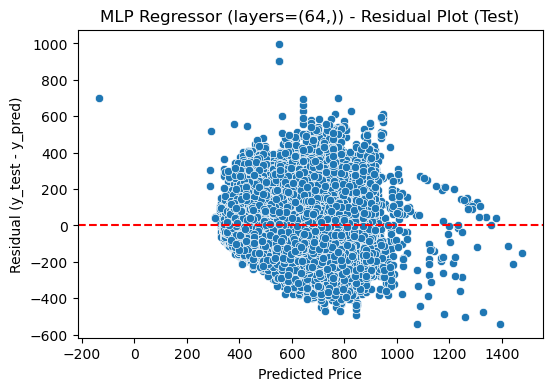

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.602, MSE: 12855.32, RMSE: 113.38, MAE: 87.13
Test  -> R2: 0.597,  MSE: 12970.63,  RMSE: 113.89,  MAE: 87.65


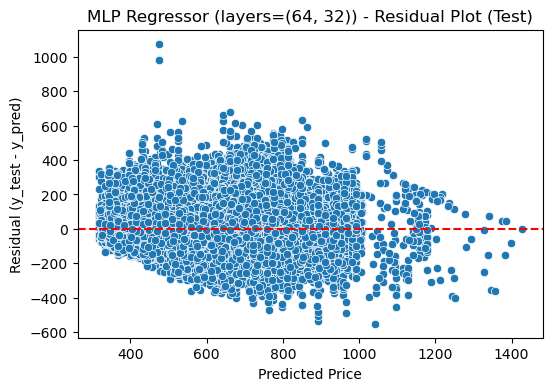

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.637, MSE: 11717.66, RMSE: 108.25, MAE: 83.50
Test  -> R2: 0.631,  MSE: 11886.86,  RMSE: 109.03,  MAE: 84.21


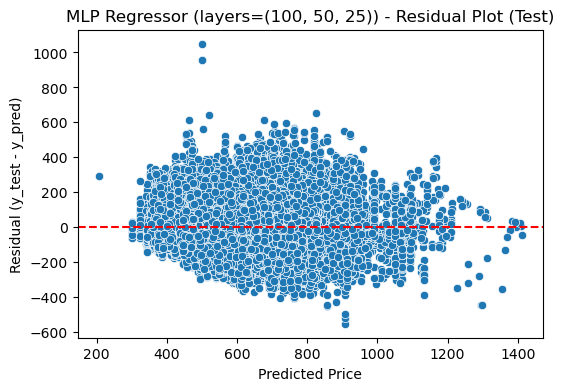

In [ ]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config, 
                       max_iter=500,       # מספר epochs
                       random_state=42)
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.518, MSE: 15559.14, RMSE: 124.74, MAE: 97.69
Test  -> R2: 0.516,  MSE: 15581.09,  RMSE: 124.82,  MAE: 97.94


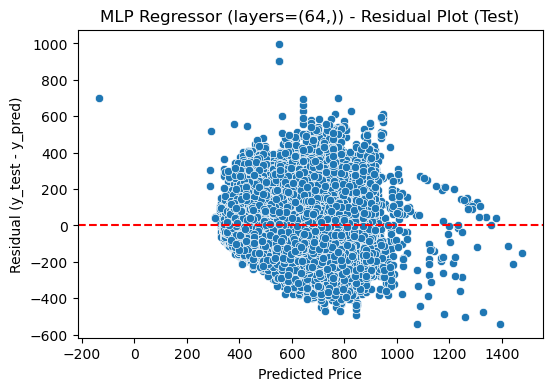

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.602, MSE: 12855.32, RMSE: 113.38, MAE: 87.13
Test  -> R2: 0.597,  MSE: 12970.63,  RMSE: 113.89,  MAE: 87.65


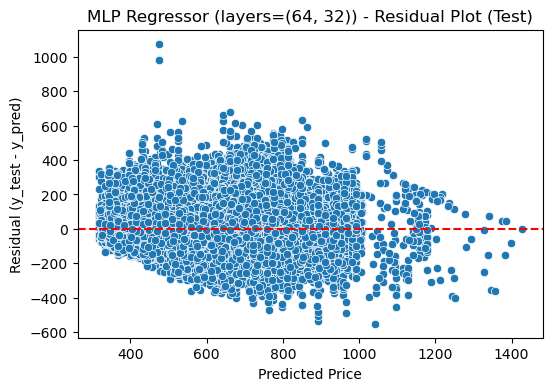

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.637, MSE: 11717.66, RMSE: 108.25, MAE: 83.50
Test  -> R2: 0.631,  MSE: 11886.86,  RMSE: 109.03,  MAE: 84.21


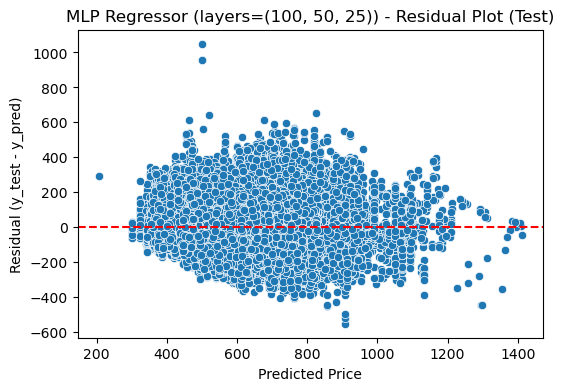

In [ ]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config, 
                       max_iter=500,       # מספר epochs
                       random_state=42)
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

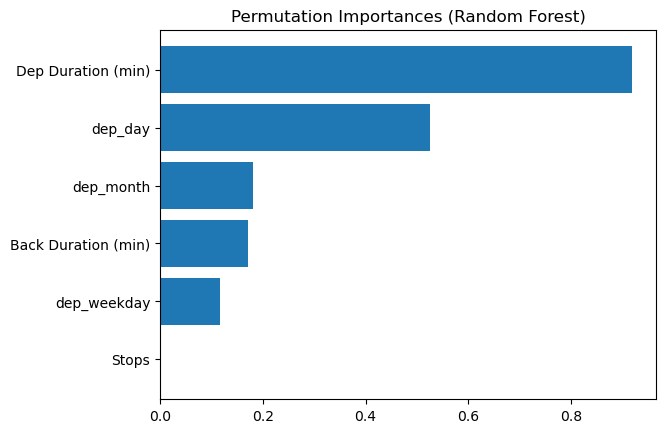

In [ ]:
r = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (Random Forest)")
plt.show()


=== Random Forest with TTT-based Split ===
Train -> R2=0.658
Test  -> R2=-2.286, RMSE=239.61, MAE=175.85


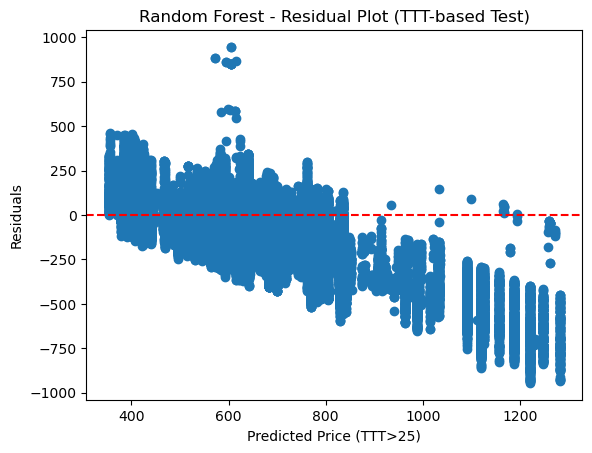

In [ ]:
df_TTT_train = df[df["TTT"] <= 25].copy()
df_TTT_test  = df[df["TTT"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["Price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["Price"]

# גם כאן נרצה לעשות סקלינג חדש:
scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)

# נאמן שוב Random Forest כמודל לדוגמה
rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=42)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)

y_pred_train_ttt = rf_ttt.predict(X_train_ttt_scaled)
y_pred_test_ttt  = rf_ttt.predict(X_test_ttt_scaled)

r2_train_ttt = r2_score(y_train_ttt, y_pred_train_ttt)
r2_test_ttt  = r2_score(y_test_ttt, y_pred_test_ttt)
mse_test_ttt = mean_squared_error(y_test_ttt, y_pred_test_ttt)
rmse_test_ttt = np.sqrt(mse_test_ttt)
mae_test_ttt = mean_absolute_error(y_test_ttt, y_pred_test_ttt)

print("=== Random Forest with TTT-based Split ===")
print(f"Train -> R2={r2_train_ttt:.3f}")
print(f"Test  -> R2={r2_test_ttt:.3f}, RMSE={rmse_test_ttt:.2f}, MAE={mae_test_ttt:.2f}")

# תרשים שאריות גם כאן
residuals_ttt = y_test_ttt - y_pred_test_ttt
plt.scatter(y_pred_test_ttt, residuals_ttt)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price (TTT>25)")
plt.ylabel("Residuals")
plt.title("Random Forest - Residual Plot (TTT-based Test)")
plt.show()

In [ ]:
for k in [3, 5, 10]:  # דוגמה ל-K שונים
    knn = KNeighborsRegressor(n_neighbors=k)
    model_name = f"KNN Regressor (n_neighbors={k})"
    trained_knn = train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, model_name)


=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.518, MSE: 15559.14, RMSE: 124.74, MAE: 97.69
Test  -> R2: 0.516,  MSE: 15581.09,  RMSE: 124.82,  MAE: 97.94


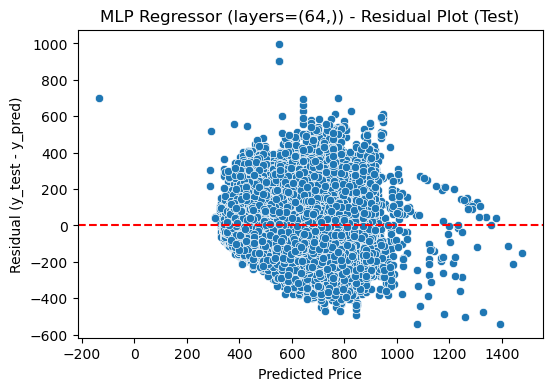

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.602, MSE: 12855.32, RMSE: 113.38, MAE: 87.13
Test  -> R2: 0.597,  MSE: 12970.63,  RMSE: 113.89,  MAE: 87.65


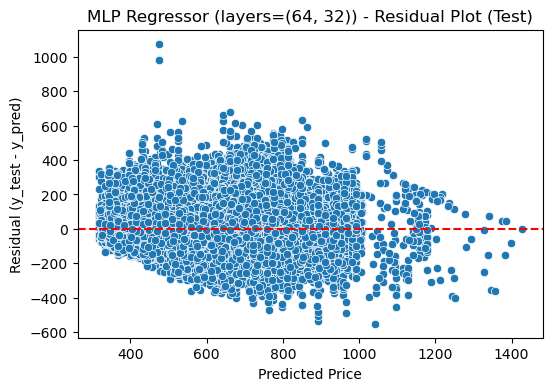

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.637, MSE: 11717.66, RMSE: 108.25, MAE: 83.50
Test  -> R2: 0.631,  MSE: 11886.86,  RMSE: 109.03,  MAE: 84.21


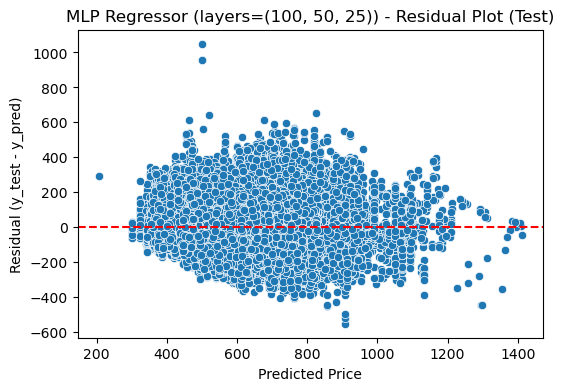

In [16]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config, 
                       max_iter=500,       # מספר epochs
                       random_state=42)
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.518, MSE: 15559.14, RMSE: 124.74, MAE: 97.69
Test  -> R2: 0.516,  MSE: 15581.09,  RMSE: 124.82,  MAE: 97.94


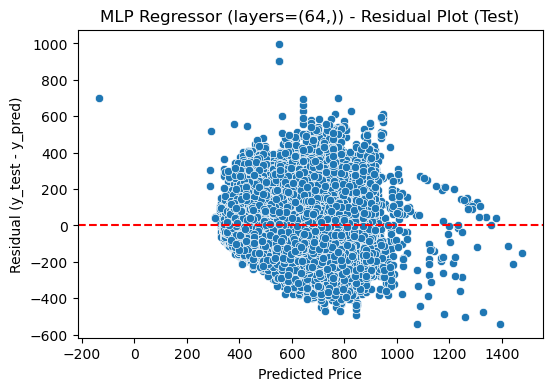

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.602, MSE: 12855.32, RMSE: 113.38, MAE: 87.13
Test  -> R2: 0.597,  MSE: 12970.63,  RMSE: 113.89,  MAE: 87.65


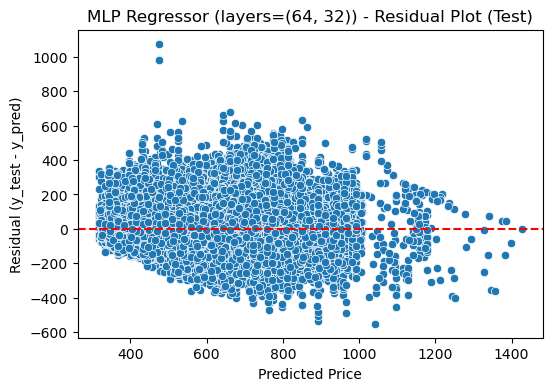

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.637, MSE: 11717.66, RMSE: 108.25, MAE: 83.50
Test  -> R2: 0.631,  MSE: 11886.86,  RMSE: 109.03,  MAE: 84.21


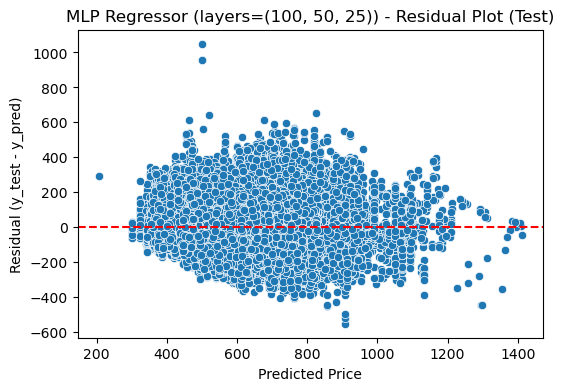

In [17]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config, 
                       max_iter=500,       # מספר epochs
                       random_state=42)
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

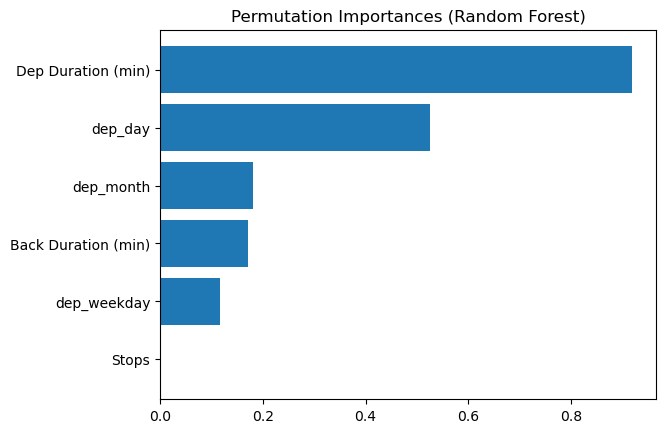

In [18]:
r = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (Random Forest)")
plt.show()


=== Random Forest with TTT-based Split ===
Train -> R2=0.658
Test  -> R2=-2.286, RMSE=239.61, MAE=175.85


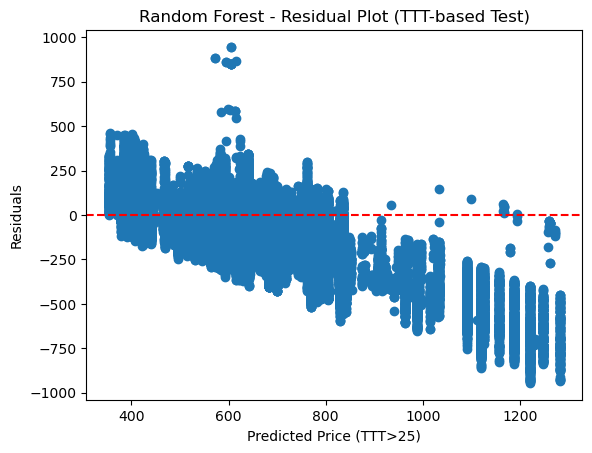

In [20]:
df_TTT_train = df[df["TTT"] <= 25].copy()
df_TTT_test  = df[df["TTT"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["Price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["Price"]

# גם כאן נרצה לעשות סקלינג חדש:
scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)

# נאמן שוב Random Forest כמודל לדוגמה
rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=42)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)

y_pred_train_ttt = rf_ttt.predict(X_train_ttt_scaled)
y_pred_test_ttt  = rf_ttt.predict(X_test_ttt_scaled)

r2_train_ttt = r2_score(y_train_ttt, y_pred_train_ttt)
r2_test_ttt  = r2_score(y_test_ttt, y_pred_test_ttt)
mse_test_ttt = mean_squared_error(y_test_ttt, y_pred_test_ttt)
rmse_test_ttt = np.sqrt(mse_test_ttt)
mae_test_ttt = mean_absolute_error(y_test_ttt, y_pred_test_ttt)

print("=== Random Forest with TTT-based Split ===")
print(f"Train -> R2={r2_train_ttt:.3f}")
print(f"Test  -> R2={r2_test_ttt:.3f}, RMSE={rmse_test_ttt:.2f}, MAE={mae_test_ttt:.2f}")

# תרשים שאריות גם כאן
residuals_ttt = y_test_ttt - y_pred_test_ttt
plt.scatter(y_pred_test_ttt, residuals_ttt)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price (TTT>25)")
plt.ylabel("Residuals")
plt.title("Random Forest - Residual Plot (TTT-based Test)")
plt.show()

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)